<a href="https://www.kaggle.com/code/martinab/homer-simpson-sentiment-analysis?scriptVersionId=160304165" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The Simpsons: Sentiment Analysis for Homer

In this project we will try to determine if Homer's speaking line is positive, negative or neutral by using VADER. We will be also using NRC Emotion Lexicon to establish proportion of speech related to certain emotion, creating wordclouds and treemap for top 50 most frequent words used by Homer Simpson. 

![simpsons](https://wallpaperaccess.com/full/535134.jpg)

### Importing Libraries

Before we import libraries we will need to install vaderSentiment. For this purpose we will just run pip install ... command below.

In [1]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 11.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import regex (regular expression operation):
import re

# Importing numpy, pandas, matplotlib and seaborn:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for plotly:
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


# To keep graph within the nobebook:
%matplotlib inline

# Libraries for NLP:
import nltk
import spacy


# Imports for Wordcloud:
from PIL import Image
import urllib
from wordcloud import WordCloud, ImageColorGenerator

# Scattertext
import scattertext as st

# Import sentiment analyzer from vaderSentiment:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import collections (Counter):
import collections

# To hide warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Explore what's in the-simpsons-dataset folder:
import os

print(os.listdir('../input/the-simpsons-dataset/'))

['simpsons_script_lines.csv', 'simpsons_episodes.csv', 'datapackage.json', 'simpsons_locations.csv', 'simpsons_characters.csv']


### Loading Data and Initial Exploration

We will be working with script lines, so let's load simpsons_script_lines.csv into a new dataframe df. 

In [4]:
# Create a dataframe df from the-simpsons-dataset/simpsons_script_lines.csv:
df = pd.read_csv('../input/the-simpsons-dataset/simpsons_script_lines.csv')

In [5]:
# Show 5 random rows from df dataset:
display(df.sample(n=5))

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
109463,119637,421,150,Lisa Simpson: What'd you get for me?,725000,True,9,5.0,Lisa Simpson,Simpson Home,What'd you get for me?,whatd you get for me,5
113500,123694,437,190,Bart Simpson: I'm tired of talking about Milho...,1053000,True,8,1588.0,Bart Simpson,South Street Squidport,I'm tired of talking about Milhouse!,im tired of talking about milhouse,6
116537,126727,450,212,Moe Szyslak: You don't get a beatin' like this...,982000,True,17,3660.0,Moe Szyslak,Springfield Union Station,You don't get a beatin' like this travelling b...,you dont get a beatin like this travelling by ...,10
90264,100235,348,252,Lisa Simpson: (TERRIFIED) We're going downhill...,1105000,True,9,1296.0,Lisa Simpson,RV,We're going downhill... and I can't reach the ...,were going downhill and i cant reach the brakes,9
93727,103761,361,250,"Seymour Skinner: (CONFUSED) What, a wall?",1163000,True,3,3.0,Seymour Skinner,Springfield Elementary School,"What, a wall?",what a wall,3


In [6]:
# Function to describe variables:
def desc(df):
    d = pd.DataFrame(df.dtypes,columns=['Data_Types'])
    d = d.reset_index()
    d['Columns'] = d['index']
    d = d[['Columns','Data_Types']]
    d['Missing'] = df.isnull().sum().values    
    d['Uniques'] = df.nunique().values
    return d

# Apply desc to df:
tab = ff.create_table(desc(df))
tab.show()

**Change data types, add columns for word_count and tens for tenth of episode:**

In [7]:
# Change columns [3:12] to string:
columns = list(df.columns)

df[columns[3:12]] = df[columns[3:12]].astype(str)

# Word count for normalized_text:
from nltk import word_tokenize
df['word_count'] = df['normalized_text'].apply(word_tokenize).apply(len)

df['tens'] = (df.episode_id//10+1)*10 

### Exploratory Data Analysis (EDA)

#### How many episodes?

In [8]:
episodes = list(df.episode_id.unique())
eposodes = episodes.sort()

print('# of Episodes:', len(episodes), '  Max. ', max(episodes), '  Min.', min(episodes)) 

# of Episodes: 564   Max.  568   Min. 1


We have 564 unique episodes in The Simpsons dataset. From episode 1 to episode 568 (this means that 4 episodes are missing).

#### Unique Categories for Speaking lines

In [9]:
# Print unique speaking line categories:
print(df.speaking_line.unique())

['True' 'False' 'false' 'true' 'Guess what. I also play Frankenstein!']


In [10]:
# Let's have a look at Frankenstein category of speaking line:
df[df.speaking_line == 'Guess what. I also play Frankenstein!']

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,tens
142024,152461,546,20,"""ABRAHAM LINCOLN: (FURIOUS) Guess what. I also...",Springfield Elementary School,Guess what. I also play Frankenstein!,guess what i also play frankenstein,6.0,nan,nan,nan,nan,1,550


In [11]:
# Map categories for speaking_line:

line = {'true': 'True'
        , 'false': 'False'
        , 'True': 'True'
        , 'False': 'False'
        , 'Guess what. I also play Frankenstein!' : 'Frankenstein'
       }

df['speaking_line'] = df.speaking_line.map(line)

#### Simpsons characters

In [12]:
# Compare number of unique character ids and names:

characters = list(df.raw_character_text.unique())
ids = list(df.character_id.unique())

print('# of Characters in raw_character_text :', len(characters))

print('# of Characters in character_id :', len(ids)) 

# of Characters in raw_character_text : 6766
# of Characters in character_id : 7186


From description table we can see that there are 6,766 unique characters in raw_character_text column, but looking at character_id we have 7,186 unique characters.

In [13]:
# List of all characters in raw_character_text column:

characters = []
for person in df['raw_character_text']:
    characters.append(person)
        
# List top 25 words according to frequency of speaking_lines:

from collections import Counter
character = dict(Counter(characters).most_common())
del character['nan']

# Create a dataframe df_char that holds character and # of speaking lines:
df_char = pd.DataFrame.from_dict(character, orient='index').reset_index()
df_char.columns = ['Character', 'Volume']

Wordcloud for Simpsons Characters (Speaking lines volume)


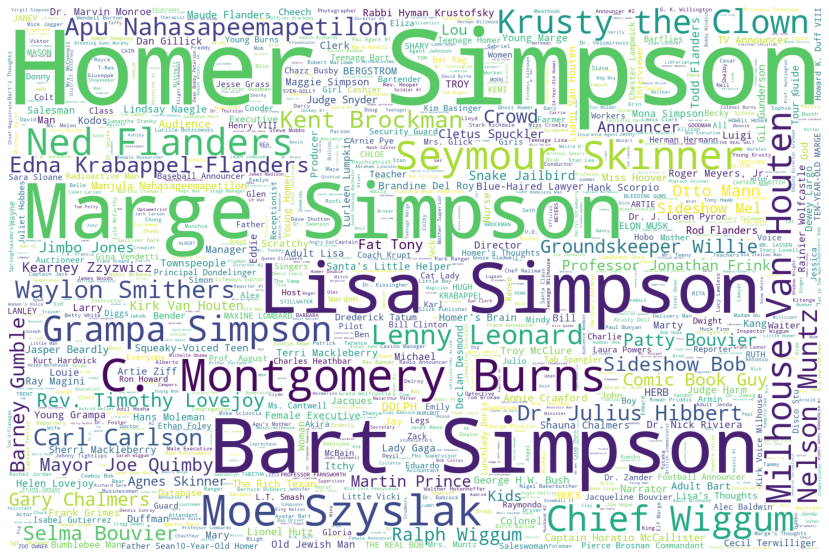

In [14]:
# Create wordcloud:

print('Wordcloud for Simpsons Characters (Speaking lines volume)')

# Create WordCloud: 
wc = WordCloud(  width= 1500
               , height=1000
               , max_words=1000
               , max_font_size = 300
               #, mask = mask
               , background_color='white'
               , random_state = 42 
              )

# Generate word cloud
wc.generate_from_frequencies(character)

# Set size to image 
plt.figure(figsize=[20,10])

# Show, swich off axis:
plt.imshow(wc)
plt.axis('off')

plt.show()

We will now focus on Simpsons family only (Homer, Marge, Bart, Lisa). Maggie is mute and has only a very few speaking lines, so will exclude her from the simpsons dataset. 

In [15]:
# Create simpsons dataframe:
simpsons = df[df['raw_character_text'].isin(['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson'])]
simpsons = simpsons.reset_index(drop=True)
simpsons = simpsons.dropna()

In [16]:
# Import required libraries:
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

# Assign english stopwords to stopword:
stopwords = list(STOP_WORDS)
new_stopwords = ['im', 'youre', 'youll', 'ill', 'ive', 'hes', 'thats', 'theres', 'id', 'cant', 'couldnt', 'shes']

# Use a simple function to append elements of new_stopwords to stopwords:
for i in new_stopwords:
    stopwords.append(i)

In [17]:
# Create a new column cleaned_text by using 'normalized_text' and removing stopwords:
simpsons['cleaned_text'] = simpsons.normalized_text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [18]:
# Create bar chart for class distribution:

df_info = simpsons[['raw_character_text']]
df_info['frequency'] = 0 
df_info = pd.DataFrame(df_info.groupby(['raw_character_text']).count()).reset_index()

data=go.Bar( x = df_info.raw_character_text
           , y = df_info.frequency
           ,  marker=dict( color=['#33C7FF', '#00e545',  '#FF33F3','#8E00B2'])
           , text=df_info.frequency
           , textposition='auto' 
           )

layout = go.Layout( title = 'Speaking lines by Simpsons'
                  , xaxis = dict(title = 'Character')
                  , yaxis = dict(title = '# of lines')
                  )

fig = go.Figure(data,layout)

fig.show()

In [19]:
# Box plot for #of Words per Episode:

df_chat = simpsons[['episode_id','raw_character_text', 'word_count']]
df_chat = pd.DataFrame(df_chat.groupby(['episode_id', 'raw_character_text'])['word_count'].sum()).reset_index()
df_chat.columns = ['Episode', 'CHARACTER', '# of words']


fig = px.box(df_chat
             , x='CHARACTER'
             , y='# of words'
             , points='all'
             , color='CHARACTER'
             , color_discrete_sequence=['#33C7FF', '#00e545',  '#FF33F3','#8E00B2']
             , title='Distribution #of Words (by Episode)'
             )

fig.show()

From the graphs above, we can see that Homer has the most speaking lines across available episodes.

## Homer Simpson - Sentiment Analysis

In [20]:
hs = simpsons[simpsons.raw_character_text == 'Homer Simpson'].reset_index(drop = True)

The code below is an application of VADER on spoken_words columns. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

It produces four sentiment metrics from word ratings: positive, neutral, negative and compound.

First three represent the proportion of the text that falls into those categories. Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).


In [21]:
analyzer = SentimentIntensityAnalyzer()

sentiment = hs['spoken_words'].apply(analyzer.polarity_scores)
sentiment_df = pd.DataFrame(sentiment.tolist())

# Concatenate df and sentimet DataFrames together:
hs = pd.concat([hs,sentiment_df], axis = 1)

NRC Emotion Lexicon is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive).

The function below returns new columns with number count for each of the emotions.

In [22]:
# Create function for extracting emotion into DataFrame:

# Import required libraries:
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import tqdm

def text_emotion(df, column):
    new_df = df.copy()
    new_df[column] = new_df[column].astype(str)

    url = 'https://raw.githubusercontent.com/sebastianruder/emotion_proposition_store/master/NRC-Emotion-Lexicon-v0.92/NRC_emotion_lexicon_list.txt'

    emolex_df = pd.read_csv(url,  names=["word", "emotion", "association"], sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns = 'emotion',
                                   values = 'association').reset_index()

    emotions = emolex_words.columns.drop('word') 
    
    emo_df = pd.DataFrame(0, index = df.index, columns = emotions)

    stemmer = SnowballStemmer('english')

    for i, row in new_df.iterrows():
        document = word_tokenize(new_df.loc[i][column])
        for word in document:
            word = stemmer.stem(word.lower())
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df.at[i, emotion] += emo_score[emotion]
               
    return pd.DataFrame(emo_df)

In [23]:
# Create a new DataFrame called data by applying text_emotion function on No_Stopwords column in df:
data = text_emotion(hs,'spoken_words')

In [24]:
# Concatenate df and data to create a homer DataFrame:
homer = pd.concat([hs, data], axis = 1)
homer.head()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,9660,33,5,Homer Simpson: (INDIGNANT) Never thrown a part...,97000,True,2.0,5.0,Homer Simpson,Simpson Home,...,0,0,0,0,0,0,0,0,0,0
1,9605,32,265,"Homer Simpson: (MULLING IT OVER, LOW, TO HIMSE...",1070000,True,2.0,5.0,Homer Simpson,Simpson Home,...,1,2,0,0,1,1,1,1,1,1
2,9609,32,269,Homer Simpson: Oh.,1086000,True,2.0,5.0,Homer Simpson,Simpson Home,...,0,0,0,0,0,0,0,0,0,0
3,9611,32,271,Homer Simpson: And?,1088000,True,2.0,5.0,Homer Simpson,Simpson Home,...,0,0,0,0,0,0,0,0,0,0
4,9613,32,273,"Homer Simpson: Hey, just because I don't care ...",1091000,True,2.0,5.0,Homer Simpson,Simpson Home,...,0,0,0,0,0,0,0,0,0,0


### VADER

In [25]:
# Create vader_df with mean values per episode:
vader_hom = homer[['episode_id','pos','neu','neg', 'compound']].copy()

# Calculate mean per episode:
df_vader_hom = vader_hom.groupby('episode_id').mean()



# Create a line Graph for VADER Sentiment:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_vader_hom.index,
    y=df_vader_hom.pos,
    name = 'Positive',
    mode='lines',
    line=dict(width=2, color='#00AAAA'),
    stackgroup='one'
))

fig.add_trace(go.Scatter(
    x=df_vader_hom.index,
    y=df_vader_hom.neg,
    name = 'Negative',
    mode='lines',
    line=dict(width=2, color='#FF0000'),
    stackgroup='one'
))

fig.update_layout(
    title = 'Homer: Positive vs. Negative',
    yaxis_title='%',
    xaxis_title='episode',
    height = 650

)

fig.show()

In [26]:
# Compound Score per Episode:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_vader_hom.index,
    y=df_vader_hom.compound,
    name = 'Compound',
    mode='lines',
    line=dict(width=2, color='#00AAAA'),
    stackgroup='one' # define stack group
))

fig.update_layout(
    title = 'Homer - Compound Score Per Episode',
    yaxis_title='score',
    xaxis_title='episode',
    height = 650
)

fig.show()

From the compund score: Homer's sentiment is very neutral, it means that the score is between 0.5 and -0.5. However, compound score is mostly in positive values. The highest score has Homer's sentiment for episode 536 (0.30), the lowest is for episode 130 (-0.19).

### NRC Emotion Lexicon

In [27]:
emotions_h = homer[['tens','anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust', 'word_count']].copy()
df_nrc_h = emotions_h.groupby('tens').sum()


emotion = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

for e in emotion:
    df_nrc_h[e] = df_nrc_h[e] * 100 /df_nrc_h['word_count']
  

In [28]:
# HOMER's Emotions:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.anticipation,
    name = 'Anticipation',
    mode='lines',
    line=dict(width=0.5, color='#32cebd'),
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.joy,
    name = 'Joy',
    mode='lines',
    line=dict(width=0.5, color='#4d2af0'),
    stackgroup='one'
))
fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.trust,
    name = 'Trust',
    mode='lines',
    line=dict(width=0.5, color='#120d6c'),
    stackgroup='one'
))
fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.surprise,
    name = 'Surprise',
    mode='lines',
    line=dict(width=0.5, color='#BB00BB'),
    stackgroup='one'
))

fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.anger,
    name = 'Anger',
    mode='lines',
    line=dict(width=0.5, color='#440411'),
    stackgroup='one'
))
fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.disgust,
    name = 'Disgust',
    mode='lines',
    line=dict(width=0.5, color='#f33828'),
    stackgroup='one'
))
fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.fear,
    name = 'Fear',
    mode='lines',
    line=dict(width=0.5, color='#ff7755'),
    stackgroup='one'
))
fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.sadness,
    name = 'Sadness',
    mode='lines',
    line=dict(width=0.5, color='#ff8100'),
    stackgroup='one'
))

fig.update_layout(
    title = 'Emotion Sentiment - (Grouped by 10 Episodes)',
    yaxis_title='%',
    xaxis_title='episode',
    height = 650
    #boxmode='group' # group together boxes of the different traces for each value of x
)

#fig.update_layout(yaxis_range=(0, 35))
fig.show()


In [29]:
# Create a line Graph for Positive vs Negative Emotion:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.positive,
    name = 'Positive',
    mode='lines',
    line=dict(width=2, color='#00AAAA'),
    stackgroup='one'
))

fig.add_trace(go.Scatter(
    x=df_nrc_h.index,
    y=df_nrc_h.negative,
    name = 'Negative',
    mode='lines',
    line=dict(width=2, color='#FF0000'),
    stackgroup='one'
))

fig.update_layout(
    title = 'NRC Lexicon: Positive vs. Negative Emotion',
    yaxis_title='%',
    xaxis_title='episode',
    height = 650

)

fig.show()

### TreeMap for Top 50 Words

In [30]:
# List of all words used in cleaned_text column:

words_content = []
for i in range(0, len(homer.cleaned_text)): 
    for word in str(homer['cleaned_text'][i]).split():
        words_content.append(word)
        
# List top 10 words according to frequency of use:
from collections import Counter
counts = dict(Counter(words_content).most_common())

In [31]:
df_rank = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_rank.columns = ['Word', 'Volume']
df_rank = df_rank[df_rank.Word != 'nan']

In [32]:
fig = px.treemap(df_rank.head(50), path=['Word'], values='Volume',title="TreeMap for Homer's top 50 Words")
fig.show()

Oh is the most frequent word in Homer's dictionary, followed by Marge, don't and like. :)